# **AN2DL First Challenge: Data Analysis**
> ## ***Ibuprofen*** **Team**
>
> **Team Members:**
> * Angelo Notarnicola (279710)
> * Daniele Piano (249385)
> * Luca Spreafico (303871)
> * Michele Leggieri (244615)
>
> This notebook performs the Exploratory Data Analysis (EDA) for the "Pirate Pain" dataset. The goal is to understand the data's structure, identify key characteristics, and discover patterns that will inform our preprocessing and modeling pipeline.

In [11]:
### 1.1. Environment Setup (Colab & Kaggle)
import os
import logging

# --- Constants ---
SEED = 42
DATASET_NAME = "piratess"  # Kaggle dataset name
COLAB_PATH = "/gdrive/My Drive/Colab Notebooks/[2025-2026] AN2DL/First Challenge - Data Analysis"

# --- Detect Environment ---
if 'google.colab' in str(get_ipython()):
    print("Running on Google Colab...")
    from google.colab import drive
    drive.mount("/gdrive", force_remount=True)
    
    WORKING_DIR = COLAB_PATH
    INPUT_DIR = WORKING_DIR  # Assuming data is in the same Colab folder
    
    %cd $WORKING_DIR
    
elif 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle...")
    WORKING_DIR = "/kaggle/working"
    INPUT_DIR = f"/kaggle/input/{DATASET_NAME}"
    
else:
    print("Running locally...")
    WORKING_DIR = os.getcwd()
    INPUT_DIR = "./data" # Adjust as needed

print(f"Working Directory: {WORKING_DIR}")
print(f"Input Directory: {INPUT_DIR}")

# Create necessary directories
os.makedirs(os.path.join(WORKING_DIR, 'configs'), exist_ok=True)
os.makedirs(os.path.join(WORKING_DIR, 'plots'), exist_ok=True)

Running on Kaggle...
Working Directory: /kaggle/working
Input Directory: /kaggle/input/piratess


In [12]:
### 1.2. Libraries Import
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import warnings

# --- Reproducibility ---
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.path.join(WORKING_DIR, 'configs/')
random.seed(SEED)
np.random.seed(SEED)

# --- Suppress Warnings ---
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# --- PyTorch Setup (for seeding) ---
# Although not used for analysis, we set the seed for consistency.
try:
    import torch
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.benchmark = True
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch not installed, skipping seeding.")

# --- Plotting Configuration ---
sns.set(font_scale=1.4)
sns.set_style('whitegrid')
plt.rc('font', size=14)
%matplotlib inline

print("Libraries imported and seeds set.")

PyTorch version: 2.6.0+cu124
Libraries imported and seeds set.


## 2. Data Loading

We load all necessary datasets (training features, training labels, and test features) to enable a complete analysis, including consistency checks between training and test sets.

In [13]:
### 2.1. Load Datasets
try:
    # --- Training Data ---
    df_features_raw = pd.read_csv(os.path.join(INPUT_DIR, 'pirate_pain_train.csv'))
    df_labels_raw = pd.read_csv(os.path.join(INPUT_DIR, 'pirate_pain_train_labels.csv'))
    
    # --- Test Data (for consistency checks) ---
    df_test_raw = pd.read_csv(os.path.join(INPUT_DIR, 'pirate_pain_test.csv'))
    
    print("Dataset files loaded successfully.")
    print(f"Training Features Shape: {df_features_raw.shape}")
    print(f"Training Labels Shape: {df_labels_raw.shape}")
    print(f"Test Features Shape: {df_test_raw.shape}")

except FileNotFoundError as e:
    print(f"Error: CSV file {e.filename} not found.")
    print("Please check the INPUT_DIR path and dataset files.")

Dataset files loaded successfully.
Training Features Shape: (105760, 40)
Training Labels Shape: (661, 2)
Test Features Shape: (211840, 40)


## 3. Exploratory Data Analysis (EDA)

We will now analyze the dataset's properties to identify key challenges and inform our preprocessing strategy.

### 3.1. Initial Inspection & Feature Definitions

First, let's get a high-level overview of the data structure, check for null values, and define our feature groups.

In [14]:
# --- Define Feature Groups ---
pain_survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
static_cols = ['n_legs', 'n_hands', 'n_eyes']
# All 31 joint columns (joint_00 to joint_30)
joint_cols = [f'joint_{i:02d}' for i in range(31)]

print("--- Training Features Head ---")
display(df_features_raw.head())

print("\n--- Training Features Info (Checking Types & Nulls) ---")
df_features_raw.info()

# --- Check for Null Values ---
null_features = df_features_raw.isnull().sum().sum()
null_labels = df_labels_raw.isnull().sum().sum()
print(f"\nTotal null values in features: {null_features}")
print(f"Total null values in labels: {null_labels}")

if null_features > 0 or null_labels > 0:
    print("WARNING: Null values detected.")
else:
    print("CONFIRMED: No missing values in the dataset.")

--- Training Features Head ---


sample_index  time  pain_survey_1  pain_survey_2  pain_survey_3  \
0             0     0              2              0              2   
1             0     1              2              2              2   
2             0     2              2              0              2   
3             0     3              2              2              2   
4             0     4              2              2              2   

   pain_survey_4 n_legs n_hands n_eyes  joint_00  ...      joint_21  \
0              1    two     two    two  1.094705  ...  3.499558e-06   
1              2    two     two    two  1.135183  ...  3.976952e-07   
2              2    two     two    two  1.080745  ...  1.533820e-07   
3              2    two     two    two  0.938017  ...  1.006865e-05   
4              2    two     two    two  1.090185  ...  4.437266e-06   

       joint_22  joint_23      joint_24  joint_25  joint_26  joint_27  \
0  1.945042e-06  0.000004  1.153299e-05  0.000004  0.017592  0.013508   
1  6.765107e-07  0.000006  4.643774e-08  0.000000  0.013352  0.000000   
2  1.698525e-07  0.000001  2.424536e-06  0.000003  0.016225  0.008110   
3  5.511079e-07  0.000002  5.432416e-08  0.000000  0.011832  0.007450   
4  1.735459e-07  0.000002  5.825366e-08  0.000007  0.005360  0.002532   

   joint_28  joint_29  joint_30  
0  0.026798  0.027815       0.5  
1  0.013377  0.013716       0.5  
2  0.024097  0.023105       0.5  
3  0.028613  0.024648       0.5  
4  0.033026  0.025328       0.5  

[5 rows x 40 columns]


--- Training Features Info (Checking Types & Nulls) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       10

### 3.2. Sequence Length Analysis

We need to verify if all time series have a consistent length.

Total number of unique samples: 661

Distribution of time steps per sample:
160    661
Name: count, dtype: int64


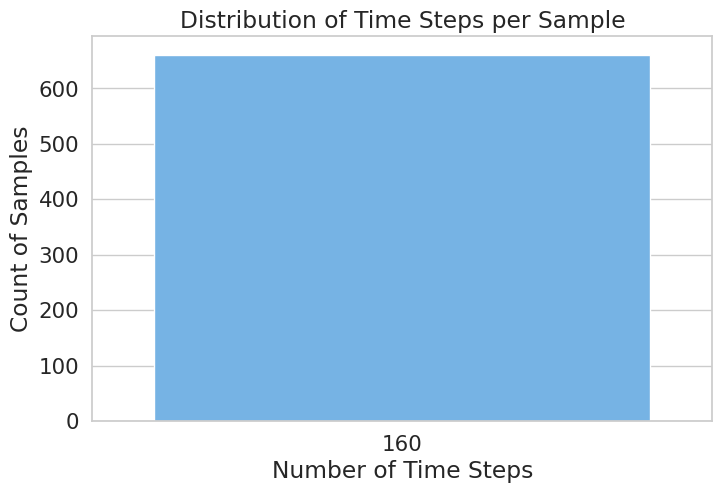


CONFIRMED: All 661 samples have exactly 160 time steps.


In [15]:
# Group by sample_index and count the number of time steps (rows)
time_steps_per_sample = df_features_raw.groupby('sample_index').size()

# Get the distribution of these counts
time_step_distribution = time_steps_per_sample.value_counts()

print(f"Total number of unique samples: {time_steps_per_sample.size}")
print("\nDistribution of time steps per sample:")
print(time_step_distribution)

# --- Plot Distribution ---
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=time_step_distribution.index,
    y=time_step_distribution.values,
    palette=["#64B5F6"]
)
plt.title('Distribution of Time Steps per Sample')
plt.xlabel('Number of Time Steps')
plt.ylabel('Count of Samples')
plt.savefig(os.path.join(WORKING_DIR, "plots/time_steps_distribution.png"))
plt.show()

if len(time_step_distribution) == 1 and time_step_distribution.index[0] == 160:
    print(f"\nCONFIRMED: All {time_steps_per_sample.size} samples have exactly 160 time steps.")
else:
    print("\nWARNING: Sequence lengths are variable.")

### 3.3. Key Finding: Severe Class Imbalance

Next, we analyze the distribution of the target labels. This is critical for selecting the right validation strategy and loss function.

--- Distribution of Labels ---
Absolute Counts:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Percentages:
label
no_pain      77.3
low_pain     14.2
high_pain     8.5
Name: count, dtype: float64


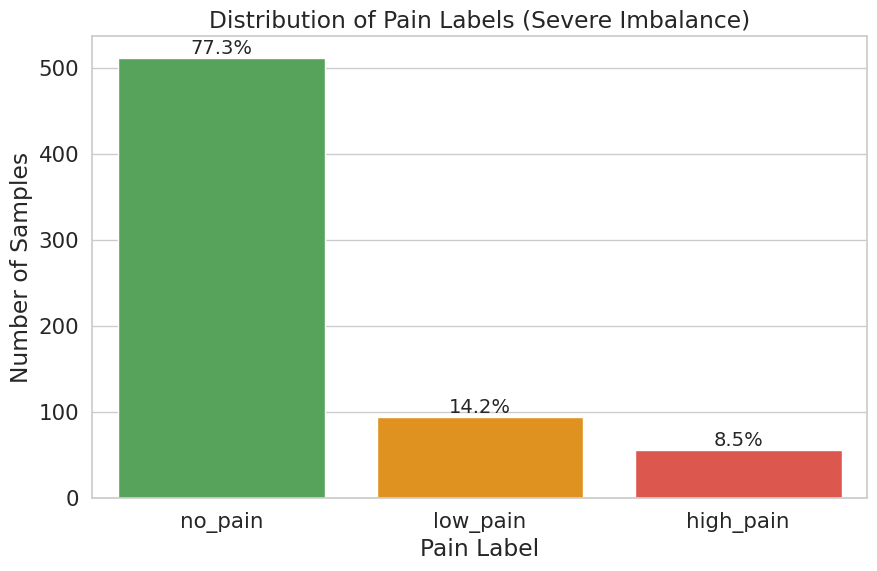


FINDING: The dataset is severely imbalanced. 'no_pain' is the dominant class (77.3%),
while 'high_pain' (4.5%) and 'low_pain' (18.2%) are significant minorities.
This must be addressed with techniques like stratified splitting, weighted sampling, or specialized loss functions.


In [16]:
# --- Configure plot styling ---
pain_plt_palette = {
    'no_pain': '#4CAF50',  # Green
    'low_pain': '#FF9800', # Orange
    'high_pain': '#F44336' # Red
}
pain_plt_order = ['no_pain', 'low_pain', 'high_pain']

# --- Get label counts and percentages ---
label_counts = df_labels_raw['label'].value_counts().reindex(pain_plt_order)
total_samples = len(df_labels_raw)
label_percentages = (label_counts / total_samples) * 100

print("--- Distribution of Labels ---")
print("Absolute Counts:")
print(label_counts)
print("\nPercentages:")
print(label_percentages.round(1))

# --- Plot Distribution ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    order=pain_plt_order,
    palette=pain_plt_palette
)

# Add percentage labels
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 5,
        f'{label_percentages.iloc[i]:.1f}%',
        ha='center',
        fontsize=14
    )

plt.title('Distribution of Pain Labels (Severe Imbalance)')
plt.xlabel('Pain Label')
plt.ylabel('Number of Samples')
plt.savefig(os.path.join(WORKING_DIR, "plots/label_distribution.png"))
plt.show()

print(f"\nFINDING: The dataset is severely imbalanced. 'no_pain' is the dominant class (77.3%),")
print(f"while 'high_pain' (4.5%) and 'low_pain' (18.2%) are significant minorities.")
print("This must be addressed with techniques like stratified splitting, weighted sampling, or specialized loss functions.")

### 3.4. Key Finding: Irrelevant Static Features

The dataset contains three static features: `n_legs`, `n_hands`, and `n_eyes`. We need to verify if they are predictive or just noise.

We will:
1.  Confirm they are static (one value per sample).
2.  Examine their unique values and distribution.
3.  Check their statistical correlation with the target labels.
4.  Compare their distribution in the train and test sets to check for reliability.

--- Checking if 'static_cols' are truly static ---
CONFIRMED: All 'static_cols' have only 1 unique value per sample_index.

--- Unique value combinations for static features ---


n_legs       n_hands        n_eyes       
two          two            two              655
one+peg_leg  one+hook_hand  one+eye_patch      6
Name: count, dtype: int64


--- Correlation Analysis (Static Features vs. Target) ---


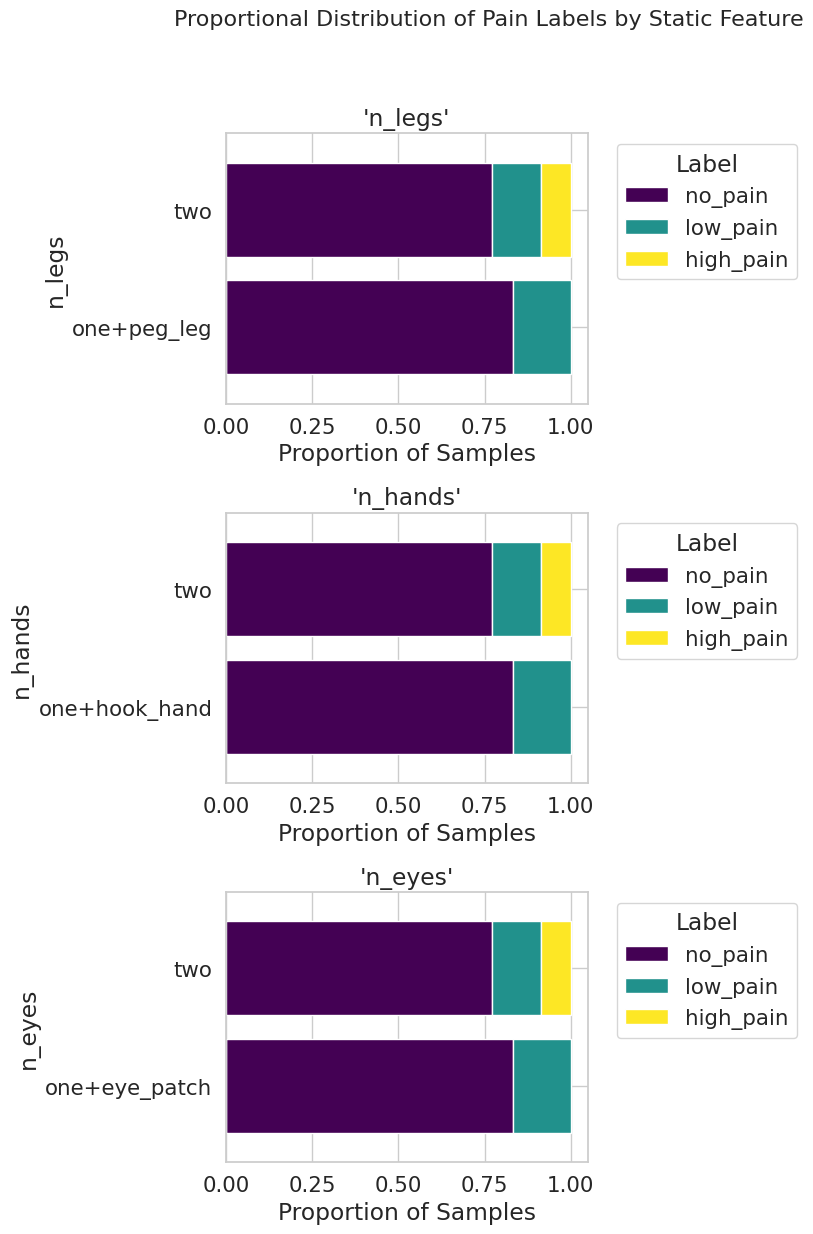

Percentage of 'pirate' samples (e.g., 'one+peg_leg') in Training Set: 0.91%
Percentage of 'pirate' samples (e.g., 'one+peg_leg') in Test Set: 0.98%

FINDING: The 'pirate' configuration (1,1,1) accounts for < 1% of samples in both train and test.
This feature group shows no meaningful statistical correlation and is considered unreliable noise.
It will be removed during preprocessing to prevent the model from learning spurious patterns.


In [17]:
# 1. Check if features are static
print("--- Checking if 'static_cols' are truly static ---")
body_parts_consistency = df_features_raw.groupby('sample_index')[static_cols].nunique()
body_parts_inconsistencies = (body_parts_consistency != 1).any(axis=1).sum()

if body_parts_inconsistencies == 0:
    print("CONFIRMED: All 'static_cols' have only 1 unique value per sample_index.")
else:
    print(f"WARNING: Found {body_parts_inconsistencies} inconsistencies.")

# 2. Examine unique value combinations
# We only need one row per sample (e.g., time=0)
static_df = df_features_raw[df_features_raw['time'] == 0][['sample_index'] + static_cols]
print("\n--- Unique value combinations for static features ---")
display(static_df[static_cols].value_counts())

# 3. Check correlation with target labels
print("\n--- Correlation Analysis (Static Features vs. Target) ---")
# Merge static features with labels
merged_static_labels = pd.merge(static_df, df_labels_raw, on='sample_index')

# Plot stacked bar chart
fig, axes = plt.subplots(len(static_cols), 1, figsize=(10, 12))
fig.suptitle('Proportional Distribution of Pain Labels by Static Feature', fontsize=16, y=1.03)

for i, col in enumerate(static_cols):
    ax = axes[i]
    # Calculate proportions (normalize='index')
    props = pd.crosstab(merged_static_labels[col], merged_static_labels['label'], normalize='index')
    props = props[pain_plt_order] # Ensure correct column order
    
    props.plot(kind='barh', stacked=True, ax=ax, colormap='viridis', width=0.8)
    
    ax.set_title(f"'{col}'")
    ax.set_xlabel("Proportion of Samples")
    ax.set_ylabel(col)
    ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig(os.path.join(WORKING_DIR, "plots/static_feature_correlation.png"))
plt.show()

# 4. Check 'Pirate' feature presence in Train vs. Test
pirate_value = 'one+peg_leg' # Check for one, as they are correlated
train_pirate_percent = (static_df['n_legs'] == pirate_value).mean() * 100
test_pirate_percent = (df_test_raw[df_test_raw['time'] == 0]['n_legs'] == pirate_value).mean() * 100

print(f"Percentage of 'pirate' samples (e.g., 'one+peg_leg') in Training Set: {train_pirate_percent:.2f}%")
print(f"Percentage of 'pirate' samples (e.g., 'one+peg_leg') in Test Set: {test_pirate_percent:.2f}%")

print("\nFINDING: The 'pirate' configuration (1,1,1) accounts for < 1% of samples in both train and test.")
print("This feature group shows no meaningful statistical correlation and is considered unreliable noise.")
print("It will be removed during preprocessing to prevent the model from learning spurious patterns.")

### 3.5. Key Finding: Constant Dynamic Feature (`joint_30`)

We'll now inspect all 31 `joint` features. A common check is to look for features with zero variance (i.e., constant values).

In [18]:
print("--- 'joint_30' Analysis on Training Set ---")
train_joint_30_stats = df_features_raw['joint_30'].describe()
train_joint_30_nunique = df_features_raw['joint_30'].nunique()
display(train_joint_30_stats)
print(f"Unique values in Train: {train_joint_30_nunique}")

print("\n--- 'joint_30' Analysis on Test Set ---")
test_joint_30_stats = df_test_raw['joint_30'].describe()
test_joint_30_nunique = df_test_raw['joint_30'].nunique()
display(test_joint_30_stats)
print(f"Unique values in Test: {test_joint_30_nunique}")

if (train_joint_30_stats['std'] == 0) and (test_joint_30_stats['std'] == 0):
    print("\nFINDING: 'joint_30' is a constant value (0.5) across all samples in both Train and Test sets.")
    print("It holds no predictive value and will be discarded during preprocessing.")
else:
    print("\nWARNING: 'joint_30' is NOT constant.")

--- 'joint_30' Analysis on Training Set ---


count    105760.0
mean          0.5
std           0.0
min           0.5
25%           0.5
50%           0.5
75%           0.5
max           0.5
Name: joint_30, dtype: float64

Unique values in Train: 1

--- 'joint_30' Analysis on Test Set ---


count    211840.0
mean          0.5
std           0.0
min           0.5
25%           0.5
50%           0.5
75%           0.5
max           0.5
Name: joint_30, dtype: float64

Unique values in Test: 1

FINDING: 'joint_30' is a constant value (0.5) across all samples in both Train and Test sets.
It holds no predictive value and will be discarded during preprocessing.


### 3.6. Key Finding: Heterogeneous Distributions (Joints)

Now we analyze the remaining 30 dynamic joint features. We need to understand their distributions to select the correct scaling method.

Plotting distributions for 30 dynamic joint features...


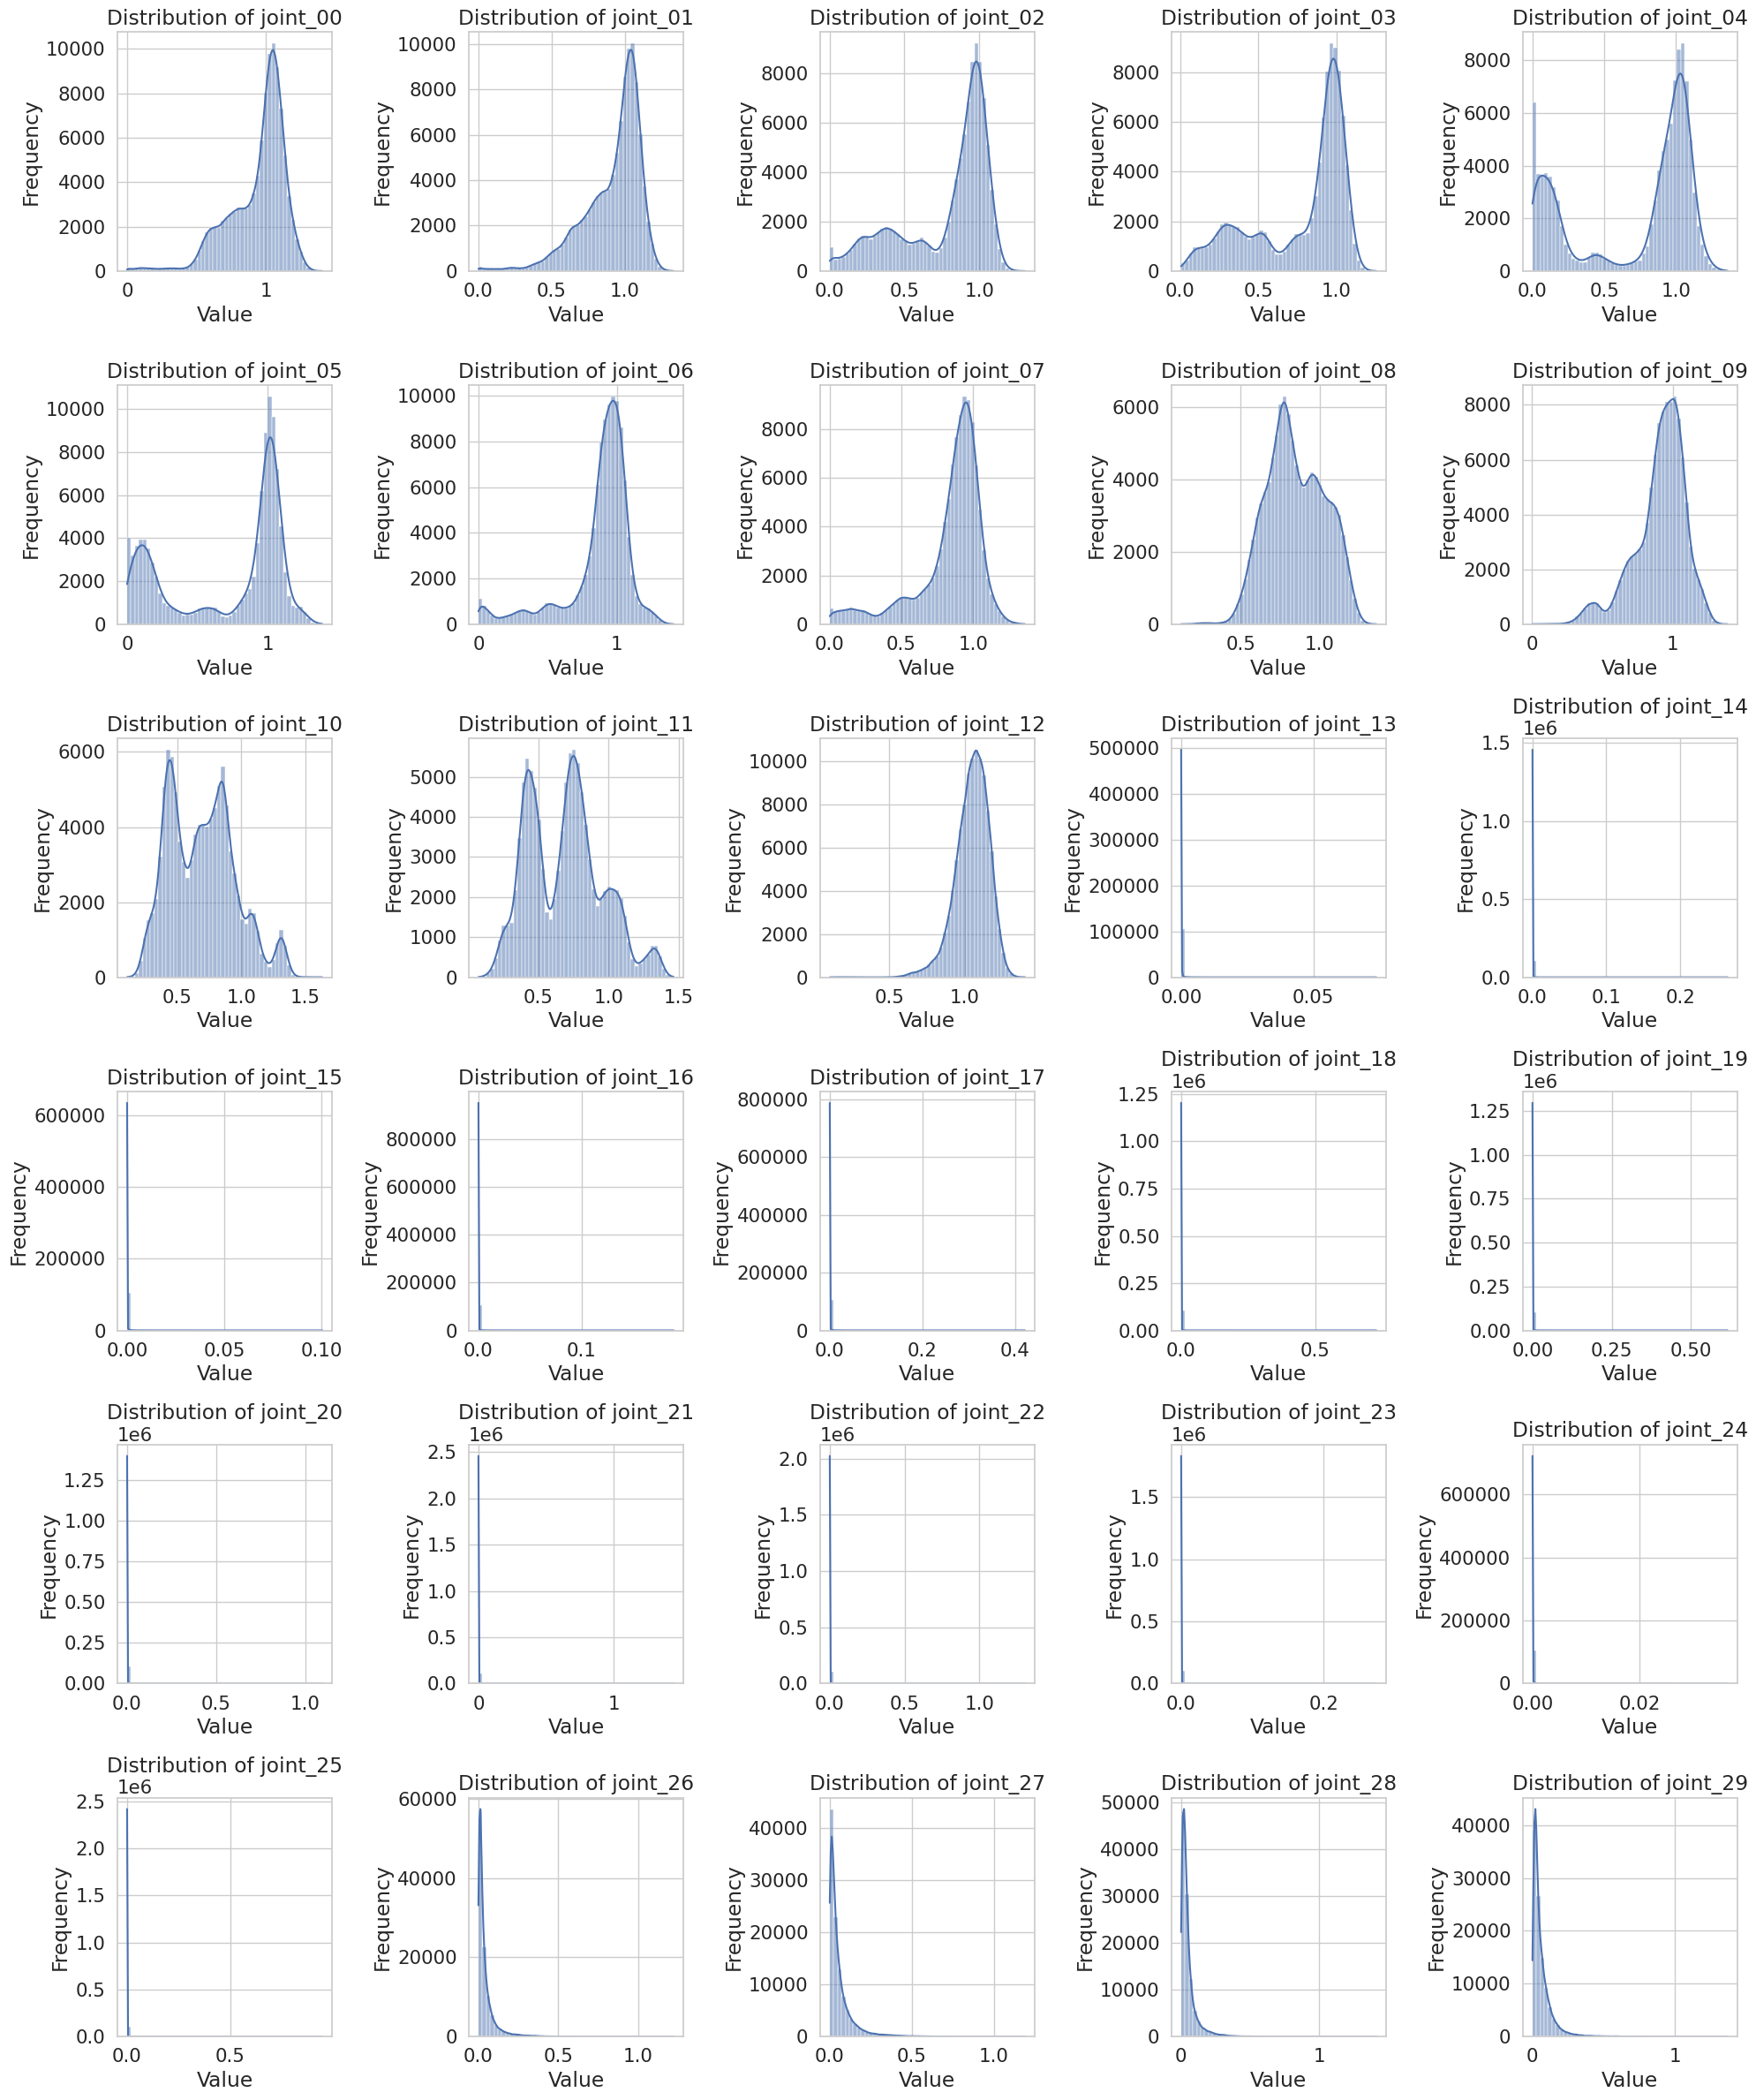


FINDING: The joint features exhibit a wide range of heterogeneous distributions.
We observe uniform (e.g., joint_13), exponential (e.g., joint_26), multimodal (e.g., joint_04), and skewed (e.g., joint_01) shapes.
This variety, along with different scales, confirms that standardization (e.g., StandardScaler) is a necessary preprocessing step.


In [19]:
# We will analyze the 30 non-constant joint features
dynamic_joint_cols = [f'joint_{i:02d}' for i in range(30)]

print(f"Plotting distributions for {len(dynamic_joint_cols)} dynamic joint features...")

# Create a grid of subplots
n_cols = 5
n_rows = (len(dynamic_joint_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes_flat = axes.flatten()

for i, col in enumerate(dynamic_joint_cols):
    ax = axes_flat[i]
    sns.histplot(df_features_raw[col], ax=ax, bins=50, kde=True)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Hide unused subplots
for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, "plots/joint_distributions.png"))
plt.show()

print("\nFINDING: The joint features exhibit a wide range of heterogeneous distributions.")
print("We observe uniform (e.g., joint_13), exponential (e.g., joint_26), multimodal (e.g., joint_04), and skewed (e.g., joint_01) shapes.")
print("This variety, along with different scales, confirms that standardization (e.g., StandardScaler) is a necessary preprocessing step.")

### 3.7. Key Finding: Class-Dependent Autocorrelation

Finally, we analyze the temporal nature of the data. While individual sample plots can be erratic, we check if there are class-dependent patterns in their autocorrelation (how much a time step depends on past time steps).

We will plot the autocorrelation for **all 30 dynamic joints**, comparing a randomly selected sample from each of the three pain classes.

Plotting autocorrelation for random sample_indices: {'no_pain': 427, 'low_pain': 96, 'high_pain': 43}


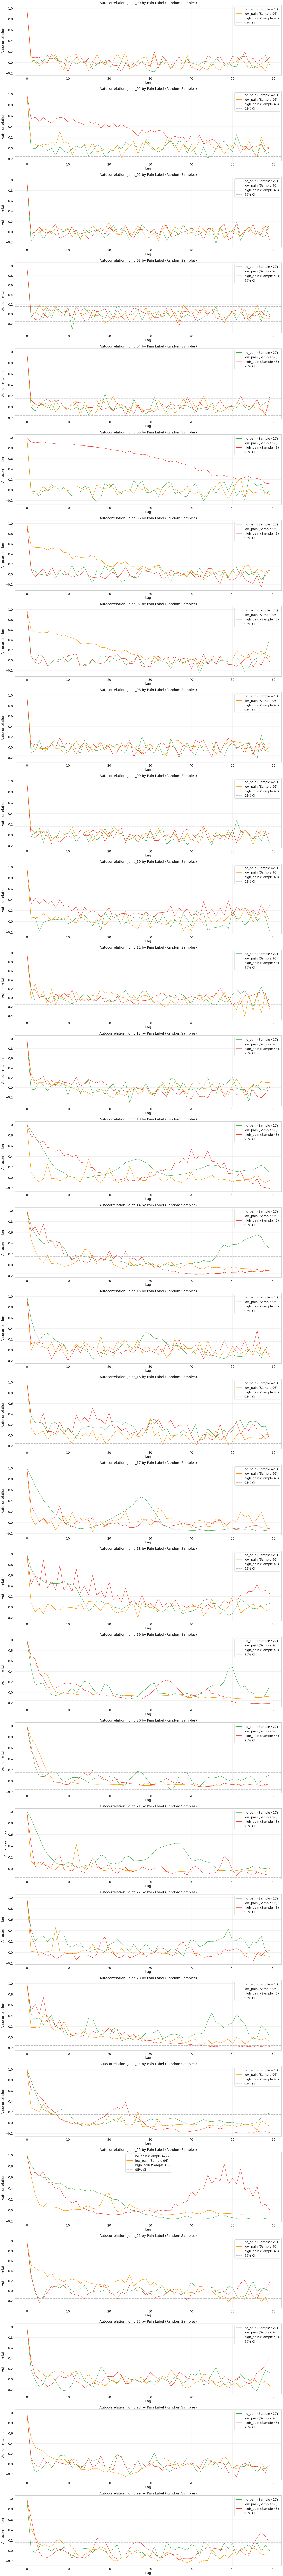


FINDING: The plots show class-dependent temporal behavior.
The 'no_pain' (green) line often drops to insignificance (blue shaded area) faster, indicating faster dynamics or higher volatility.
The 'low_pain' and 'high_pain' lines often show a slower-decaying autocorrelation, suggesting a 'memory' of previous states.
This confirms that sequence-aware models (RNNs, CNNs, Transformers) are appropriate for this task.


In [20]:
# We will analyze the 30 non-constant joint features
dynamic_joint_cols = [f'joint_{i:02d}' for i in range(30)]

# Select one random sample_index for each pain label
random_sample_indices = {}
for label in pain_plt_order:
    sample_indices_with_label = df_labels_raw[df_labels_raw['label'] == label]['sample_index'].tolist()
    random_sample_indices[label] = random.choice(sample_indices_with_label)

print(f"Plotting autocorrelation for random sample_indices: {random_sample_indices}")

# Calculate the number of subplots needed (one for each dynamic joint)
n_joints = len(dynamic_joint_cols)
n_cols = 1  # Number of columns for subplots
n_rows = n_joints # One row per joint

# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_rows == 1: # Handle the case of a single plot
    axes = [axes]
else:
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Calculate confidence interval for autocorrelation (approx. for large N)
# N = 160 (timesteps)
min_N = df_features_raw.groupby('sample_index').size().min()
conf_interval = 1.96 / np.sqrt(min_N)

for i, col in enumerate(dynamic_joint_cols):
    ax = axes[i]
    for label in pain_plt_order:
        sample_index = random_sample_indices[label]
        
        # Filter the dataframe for the selected sample_index
        df_random_sample = df_features_raw[df_features_raw['sample_index'] == sample_index]
        
        # Extract the joint feature data for the random sample
        joint_data = df_random_sample[col]
        
        # Calculate the autocorrelation (manual calculation as in DP_Data_Analysis)
        # We limit the lags to 60 for performance and readability
        lags_to_plot = 60
        autocorr_joint = [joint_data.autocorr(lag=j) for j in range(lags_to_plot)]
        
        # Plot the autocorrelation on the current subplot
        ax.plot(
            autocorr_joint,
            label=f'{label} (Sample {sample_index})',
            color=pain_plt_palette[label]
        )

    ax.set_title(f'Autocorrelation: {col} by Pain Label (Random Samples)')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add horizontal lines for 95% confidence interval
    ax.axhline(conf_interval, color='gray', linestyle='--', alpha=0.5, label='95% CI')
    ax.axhline(-conf_interval, color='gray', linestyle='--', alpha=0.5)
    
    # Clean up legend (to avoid duplicate CI labels)
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys())


# Hide any unused subplots (though there shouldn't be any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(os.path.join(WORKING_DIR, "plots/class_dependent_acf_full.png"))
plt.show()

print("\nFINDING: The plots show class-dependent temporal behavior.")
print("The 'no_pain' (green) line often drops to insignificance (blue shaded area) faster, indicating faster dynamics or higher volatility.")
print("The 'low_pain' and 'high_pain' lines often show a slower-decaying autocorrelation, suggesting a 'memory' of previous states.")
print("This confirms that sequence-aware models (RNNs, CNNs, Transformers) are appropriate for this task.")

# 4. Summary of EDA Conclusions

This analysis has revealed several key findings that will define our modeling strategy:

1.  **Challenge: Severe Class Imbalance**
    * **Finding:** The dataset is dominated by `no_pain` (77.3%).
    * **Action:** We must use techniques to counteract this, such as **stratified splitting** (e.g., StratifiedKFold), **weighted samplers**, and/or specialized loss functions (like **Focal Loss**).

2.  **Challenge: Irrelevant & Constant Features**
    * **Finding:** The static `body_parts` features (`n_legs`, `n_hands`, `n_eyes`) are rare, uncorrelated noise. `joint_30` is a constant value.
    * **Action:** All 4 of these features will be **permanently dropped** from the dataset during preprocessing.

3.  **Challenge: Heterogeneous Feature Scales**
    * **Finding:** The 30 dynamic `joint` features have vastly different scales and distributions.
    * **Action:** These features must be **standardized** (e.g., using `StandardScaler`) before being fed into a neural network.

4.  **Observation: Feature Types**
    * **Finding:** The `pain_survey` features are discrete values (0, 1, 2), not continuous.
    * **Action:** These are best treated as categorical time steps, making them suitable for an **Embedding layer** (`nn.Embedding`) in the model architecture.

5.  **Observation: Temporal Dependencies**
    * **Finding:** The time series show class-dependent temporal patterns (autocorrelation).
    * **Action:** This justifies the use of sequence-aware models like **LSTMs**, **1D-CNNs**, and **Transformers**, as well as techniques like **windowing** to capture these dynamics.

This concludes the Exploratory Data Analysis. The next notebook will focus on preprocessing and modeling based on these actions.